In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


## Contents
1. **Data Overview** <br> _We begin this study by conducting an exploratory analysis of the raw dataset using basic descriptive statistics to get a quick sense of the data._
2. **Data Cleaning** <br> _We then proceed to exclude suspicious features and employ a straightforward approach to achieve a balanced target dataset quickly._
3. **Significance tests** <br> _Next, we apply non-parametric statistical tests to assess the significance of features, relying on the large training sample to handle the majority of the work._
4. **Preprocessing** <br> _Subsequently, essential preprocessing steps are implemented to scale and encode the data into a format suitable for neural network._
5. **Deep Learning** <br> _In this section, neural network weights estimation with backpropagation is being conducted._
6. **Evaluation** <br> _Visualizing the confusion matrix, plotting the ROC curve to assess its predictive capability, and  metrics calculation._

# 1) Data Overview

Function `columns_info()`, indicating features' basic metadata and descriptive statistics for a given df, is defined in order to facilitate analysis.

In [2]:
def columns_info(df):
    # features' basic metadata and descriptive statistics for a given df
    feature_info = {
        'feature': [],
        'dtype': [],
        'nunique': [],
        'min': [],
        '25%': [],
        '50%': [],
        '75%': [],
        'max': [],
        'mean': [],
        'std_dev': []
        }

    for col in df.columns:
        feature_info['feature'].append(col)
        feature_info['dtype'].append(df[col].dtype)
        feature_info['nunique'].append(len(df[col].unique()))
        if df[col].dtype=='object':
            feature_info['min'].append(np.nan)
            feature_info['25%'].append(np.nan)
            feature_info['50%'].append(np.nan)
            feature_info['75%'].append(np.nan)
            feature_info['max'].append(np.nan)
            feature_info['mean'].append(np.nan)
            feature_info['std_dev'].append(np.nan)
        else:
            feature_info['min'].append(df[col].min())
            feature_info['25%'].append(df[col].quantile(0.25))
            feature_info['50%'].append(df[col].median())
            feature_info['75%'].append(df[col].quantile(0.75))
            feature_info['max'].append(df[col].max())
            feature_info['mean'].append(df[col].mean())
            feature_info['std_dev'].append(df[col].std())

    features = pd.DataFrame(feature_info)
    features.set_index('feature', inplace=True)
    return features

In [3]:
%%time
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
train

CPU times: user 16.3 s, sys: 3.17 s, total: 19.5 s
Wall time: 24.6 s


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [4]:
# basic info
print(f'Number of rows: {train.shape[0]}')
print(f'Number of columns: {train.shape[1]}')
print(f'Data types: {set(train.dtypes.values)}')
print(f'Missing values: {train.isnull().values.any()}')
print(f"Duplicates: {train.drop(columns='id').duplicated().sum()}")

Number of rows: 11504798
Number of columns: 12
Data types: {dtype('int64'), dtype('float64'), dtype('O')}
Missing values: False
Duplicates: 0


In [5]:
# imbalanced target variable
train.Response.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

In [6]:
# features
pd.set_option('display.float_format', lambda x: '%.2f' % x)
columns_info(train).sort_values(by='nunique', ascending=False)

,dtype,nunique,min,25%,50%,75%,max,mean,std_dev
feature,,,,,,,,,
id,int64,11504798,0.00,2876199.25,5752398.50,8628597.75,11504797.00,5752398.50,3321149.26
Annual_Premium,float64,51728,2630.00,25277.00,31824.00,39451.00,540165.00,30461.37,16454.75
Vintage,int64,290,10.00,99.00,166.00,232.00,299.00,163.90,79.98
Policy_Sales_Channel,float64,152,1.00,29.00,151.00,152.00,163.00,112.43,54.04
Age,int64,66,20.00,24.00,36.00,49.00,85.00,38.38,14.99
Region_Code,float64,54,0.00,15.00,28.00,35.00,52.00,26.42,12.99
Vehicle_Age,object,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,object,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driving_License,int64,2,0.00,1.00,1.00,1.00,1.00,1.00,0.04


# 2) Data Cleaning

In [7]:
# data cleaning
def data_clean(raw_data):
    # returns raw_data as clean as we want it 
    raw_data.set_index('id', inplace=True)
    # according to 'columns_info(train)' this feature is invariant
    raw_data.drop(columns=['Driving_License'], inplace=True)
    # Seems to be nominal; highly problematic due to 54 unique values
    raw_data.drop(columns=['Region_Code'], inplace=True)
    # Seems to be nominal; highly problematic due to 152 unique values
    raw_data.drop(columns=['Policy_Sales_Channel'], inplace=True)
    # according to 'columns_info(train)' this feature is nominal
    raw_data.Previously_Insured = raw_data.Previously_Insured.astype(str)    
    return raw_data

data_clean(train)

,Gender,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
id,,,,,,,,
0,Male,21,0,1-2 Year,Yes,65101.00,187,0
1,Male,43,0,> 2 Years,Yes,58911.00,288,1
2,Female,25,1,< 1 Year,No,38043.00,254,0
3,Female,35,0,1-2 Year,Yes,2630.00,76,0
4,Female,36,1,1-2 Year,No,31951.00,294,0
...,...,...,...,...,...,...,...,...
11504793,Male,48,0,1-2 Year,Yes,27412.00,218,0
11504794,Female,26,0,< 1 Year,Yes,29509.00,115,1
11504795,Female,29,1,< 1 Year,No,2630.00,189,0


In [8]:
# rebalanced dataset sampling
train_1 = train[train.Response==1]
train_0 = train[train.Response==0].sample(train_1.shape[0], random_state=666)
df_train = pd.concat([train_0, train_1])
df_train.Response.value_counts(normalize=True)

Response
0   0.50
1   0.50
Name: proportion, dtype: float64

In [9]:
df_train.shape

(2830118, 8)

# 3) Significance tests

In [10]:
from sklearn.model_selection import train_test_split
# train/test split
y = df_train['Response']
X = df_train.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df_train['Response'])
df_train = pd.concat([X_train, y_train], axis=1)
X_train.dtypes

Gender                 object
Age                     int64
Previously_Insured     object
Vehicle_Age            object
Vehicle_Damage         object
Annual_Premium        float64
Vintage                 int64
dtype: object

In [11]:
%%time
from scipy.stats import mannwhitneyu, chi2_contingency

# numeric features testing
for feature in X_train.select_dtypes(exclude='object').columns:
    group_0 = df_train[df_train['Response']==0][feature]
    group_1 = df_train[df_train['Response']==1][feature]
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))
        
# nominal features testing
for feature in X_train.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_train[feature], df_train['Response'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))

CPU times: user 17.4 s, sys: 732 ms, total: 18.1 s
Wall time: 18 s


# 4) Preprocessing

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

prep = make_column_transformer((StandardScaler(), X_train.select_dtypes(include='float64').columns), 
                               (MinMaxScaler(), X_train.select_dtypes(include='int64').columns),
                               (OneHotEncoder(drop='first'), X_train.select_dtypes(include='object').columns))

X_train_transformed = prep.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed

,0,1,2,3,4,5,6,7
0,-0.38,0.08,0.63,0.00,1.00,1.00,0.00,0.00
1,1.34,0.14,0.77,1.00,0.00,0.00,0.00,1.00
2,0.01,0.41,0.87,0.00,0.00,0.00,0.00,1.00
3,-1.67,0.17,0.61,1.00,0.00,1.00,0.00,1.00
4,0.47,0.78,0.71,0.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...
2264089,0.14,0.33,0.79,0.00,0.00,0.00,0.00,1.00
2264090,-0.10,0.05,0.34,1.00,0.00,1.00,0.00,1.00
2264091,0.22,0.41,0.61,0.00,0.00,0.00,0.00,1.00
2264092,0.58,0.30,0.54,1.00,0.00,0.00,0.00,1.00


# 5) Deep Learning

In [13]:
%%time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Neural network architecture
model = Sequential([
    Dense(512, input_shape=(8,), activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001)

# backpropagation
history = model.fit(
    X_train_transformed, y_train,
    epochs=10,
    batch_size=1024,  
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

2024-09-07 00:29:32.453942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:29:32.454104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:29:32.621720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - AUC: 0.8350 - loss: 0.4410 - val_AUC: 0.8488 - val_loss: 0.4257 - learning_rate: 0.0010
Epoch 2/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - AUC: 0.8470 - loss: 0.4268 - val_AUC: 0.8502 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 3/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - AUC: 0.8483 - loss: 0.4257 - val_AUC: 0.8506 - val_loss: 0.4243 - learning_rate: 0.0010
Epoch 4/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - AUC: 0.8487 - loss: 0.4256 - val_AUC: 0.8510 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 5/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - AUC: 0.8494 - loss: 0.4251 - val_AUC: 0.8516 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 6/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - AUC: 0.8495 - loss: 0.4259 - val_AUC: 0.8516 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 7/10
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - AUC: 0.8503 - loss: 0.4241 - val_AUC: 0.8519 - val_loss: 0.4229 - 

# 6) Evaluation

In [14]:
%%time
y_pred_proba = model.predict(pd.DataFrame(prep.fit_transform(X_test)), verbose=0)

CPU times: user 45.9 s, sys: 3.39 s, total: 49.3 s
Wall time: 37.8 s


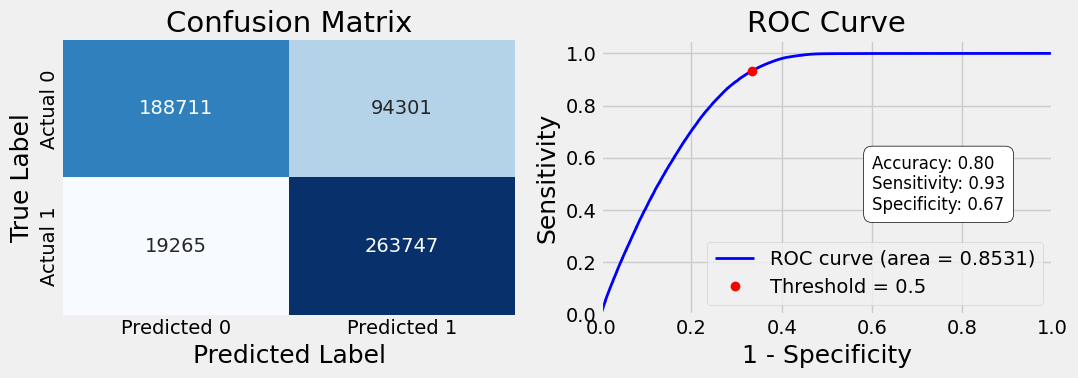

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve

# Compute confusion matrix
cm = confusion_matrix(y_test, np.where(y_pred_proba>0.5,1,0))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute accuracy, sensitivity and specificity
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
default_threshold_index = np.where(thresholds > 0.5)[0][-1]
sensitivity = tpr[default_threshold_index]
specificity = 1 - fpr[default_threshold_index]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Confusion Matrix subplot
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], 
            cbar=False, 
            ax=axes[0])

axes[0].set_title('Confusion Matrix', fontsize=21)
axes[0].set_xlabel('Predicted Label', fontsize=18)
axes[0].set_ylabel('True Label', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# ROC Curve subplot
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
axes[1].legend(loc="lower right", fontsize=14)
axes[1].text(0.6, 0.4, f'Accuracy: {accuracy:.2f}\nSensitivity: {sensitivity:.2f}\nSpecificity: {specificity:.2f}', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), 
             fontsize=12)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('1 - Specificity', fontsize=18)
axes[1].set_ylabel('Sensitivity', fontsize=18)
axes[1].set_title('ROC Curve', fontsize=21)
axes[1].plot(fpr[default_threshold_index], tpr[default_threshold_index], 'ro', label='Threshold = 0.5')
axes[1].legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.show()

In [16]:
# threshold tuning
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.50518453

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,461 (2.03 MB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 354,308 (1.35 MB)

# 7) Model Refit

In [18]:
%%time
history = model.fit(
    prep.fit_transform(X), y,
    epochs=15,
    batch_size=1024,  
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

CPU times: user 17min 35s, sys: 37.4 s, total: 18min 12s
Wall time: 5min 47s


# 8) Submission
Here comes my very first submission:

In [19]:
%%time
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
y_hat = model.predict(pd.DataFrame(prep.fit_transform(data_clean(test))), verbose=0)

submission = pd.DataFrame(test.reset_index().id).assign(Response=y_hat)
submission

CPU times: user 10min 53s, sys: 52.3 s, total: 11min 46s
Wall time: 9min 13s


,id,Response
0,11504798,0.10
1,11504799,0.73
2,11504800,0.66
3,11504801,0.00
4,11504802,0.14
...,...,...
7669861,19174659,0.63
7669862,19174660,0.00
7669863,19174661,0.00
7669864,19174662,0.76
